Num. linhas = 512
Num. colunas = 512

112


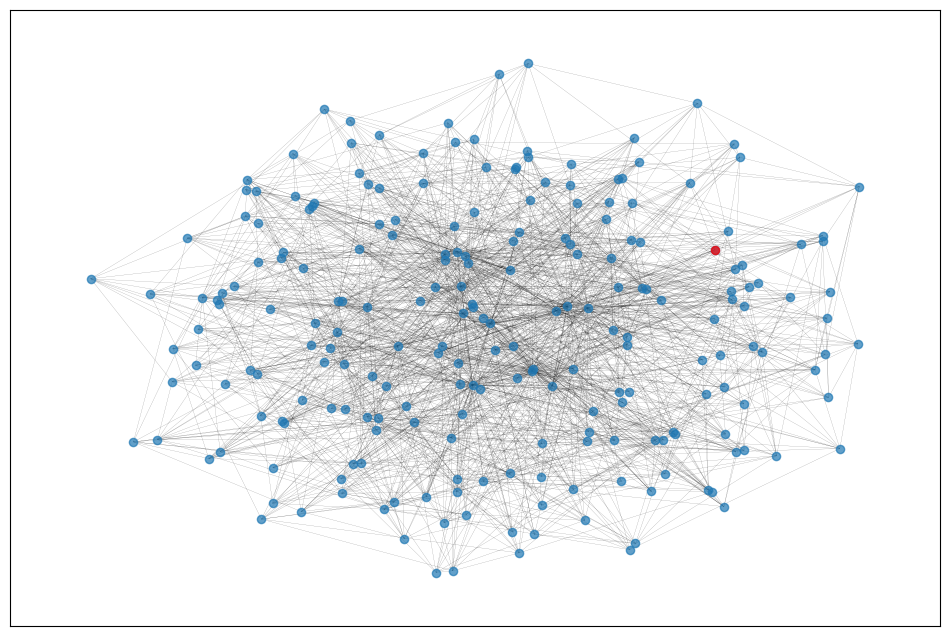

112


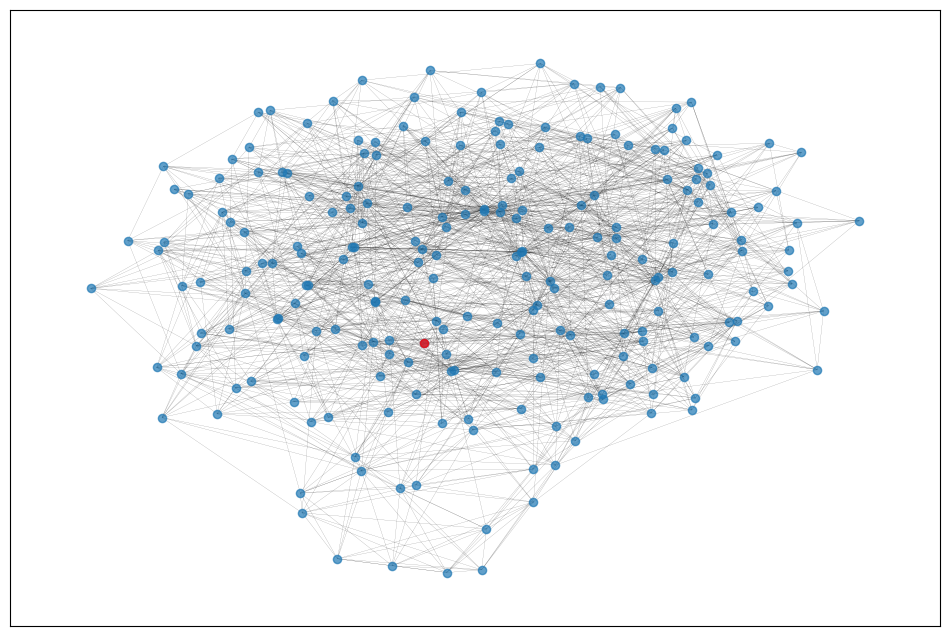

112


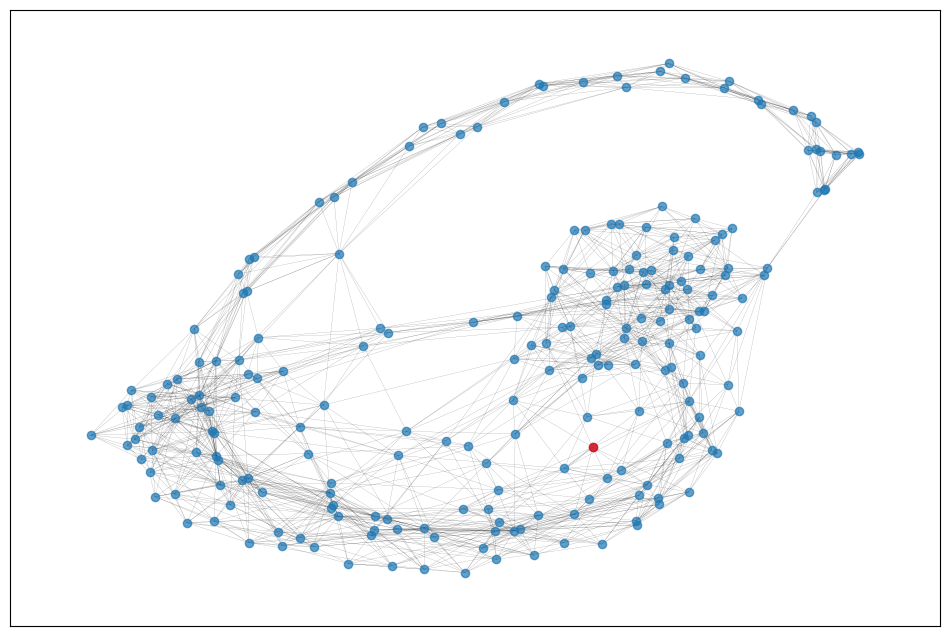

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 15 11:26:44 2019

Visualização dos patches ruidosos a partir do grafo k-NN

"""
import sys
import warnings
import time
import skimage
import statistics
import networkx as nx
import matplotlib.pyplot as plt
import skimage.io
import skimage.measure
import numpy as np
import umap
from numpy import eye
import sklearn.neighbors as sknn
from numba import njit   # just in time compiler (acelera loops)

# Para evitar warning de divisão por zero
warnings.simplefilter(action='ignore')

'''
Espelhamento das bordas da imagem A de maneira simétrica
A função pad do numpy não é supertada pelo numba! (para acelerar com jit)
Substitui a função: img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')
f é o parâmetro (largura das bordas)
'''
@njit
def mirror(A, f):
    n = A.shape[0]
    m = A.shape[1]
    nlin = A.shape[0] + 2*f
    ncol = A.shape[1] + 2*f
    # Matriz de saída
    B = np.zeros((nlin, ncol))
    # Preeenche miolo
    B[f:nlin-f, f:ncol-f] = A
    # Preenche cantos
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])                          # 1o quadrante
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])                # 2o quadrante
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])                # 3o quadrante
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])      # 4o quadrante
    # Preenche bordas
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])             # cima
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])   # baixo
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])             # esquerda
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])   # direita
    return B

'''
Função que extrai os patches de cada janela de busca no GeoNLM
i, j: posição do pixel central do patch
f: tamanho do patch
t: tamanho da janela de busca
'''
@njit
def Extract_patches_local(img, i, j, f, t):
    # Dimenssões espaciais da imagem
    m, n = img.shape
    # Tamanhos do patch e da janela de busca
    tamanho_patch = (2*f + 1)*(2*f + 1)
    # Problema de valor de contorno: replicar bordas
    img_n = mirror(img, f)
    # Loop principal do NLM geodésico
    im = i + f;   # compensar a borda adicionada artificialmente
    jn = j + f;   # compensar a borda adicionada artificialmente
    # Obtém o patch ao redor do pixel corrente
    patch_central = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1].copy()
    central = patch_central.reshape((1, patch_central.shape[0]*patch_central.shape[1]))[-1]
    # Calcula as bordas da janela de busca para o pixel corrente
    rmin = max(im-t, f);  # linha inicial
    rmax = min(im+t, m+f);  # linha final
    smin = max(jn-t, f);  # coluna inicial
    smax = min(jn+t, n+f);  # coluna final
    num_elem = (rmax - rmin + 1)*(smax - smin + 1)
    # Cria dataset
    dataset = np.zeros((num_elem, tamanho_patch))
    # Loop para montar o dataset com todos os patches da janela
    k = 0
    for r in range(rmin, rmax+1):
        for s in range(smin, smax+1):
            # Obtém o patch ao redor do pixel a ser comparado
            W = img_n[r-f:(r+f)+1, s-f:(s+f)+1].copy()
            neighbor = W.reshape((1, W.shape[0]*W.shape[1]))[-1]
            dataset[k, :] = neighbor.copy()
            if (central == neighbor).all():
                source = k
            k = k + 1
    return dataset, source

'''
 Constrói o grafo k-NN a partir de uma matriz de dados n x m
'''
def build_KNN_Graph(dados, k):
    # Função que gera grafo KNN a partir dos dados
    KNNG = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')
    # Converte para formato do networkX
    G = nx.from_scipy_sparse_array(KNNG)
    return G

'''
Plota o grafo KNN
'''
def plota_grafo(G, centro, layout):
    # Número de vértices
    n = len(G.nodes)
    # Há vários layouts
    if layout == 'kamada':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G)
    # Plota figura
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(G, pos, node_size=35, with_labels=False, width=0.1, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, node_size=35, nodelist=[centro], node_color='red', alpha=0.7)
    plt.show()


########################################
# INÍCIO DO SCRIPT
########################################
name = 'Lenna.png'
#name = 'Zebrafish.png'


img = skimage.io.imread(name)

# Checa se imagem é monocromática
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)   # valores convertidos ficam entre 0 e 1
    img = 255*img

img = img.astype(np.uint8)              # Converte para uint8
m, n = img.shape

print('Num. linhas = %d' %m)
print('Num. colunas = %d' %n)
print()

# Variancia do ruído Gaussiano
sigma = 10
ruido = np.random.normal(0, sigma, (m, n))

# Cria imagem ruidosa
ruidosa = img + ruido

# Clipa imagem para intervalo [0, 255]
ruidosa[np.where(ruidosa > 255)] = 255
ruidosa[np.where(ruidosa < 0)] = 0

# Define parâmetros do filtro NLM
f = 2   # tamanho do patch (2f + 1 x 2f + 1)
t = 7  # tamanho da janela de busca (2t + 1 x 2t + 1)

# Problema de valor de contorno: replicar bordas
img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')

#=================================================
# Análise local
#=================================================

# Define posição do patch
i = [100, 100, 250]
j = [100, 400, 250]
# centers = [(100, 100), (100, 400), (250, 250), (400, 100), (450, 450)]
# Número de vizinhos no grafo k-NN
nn = 10

# Remove os patches dentro de cada janela de busca
for k in range(len(i)):
  patches, centro = Extract_patches_local(img_n, i[k], j[k], f, t)
  print(centro)
  # Constrói grafo KNN
  G = build_KNN_Graph(patches, nn)
  # Plota grafo KNN
  plota_grafo(G, centro, 'spring')

In [8]:
G.nodes.items

<bound method Mapping.items of NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,